# Correlation

Find Pearson (maybe Spearman?) correlation between covid and library variabels

In [29]:
# Import modules
import pandas as pd
import os
import matplotlib.pyplot as plt

# Load data
library_path = "../Data/merged_library_covid_outer.csv"
df = pd.read_csv(library_path)
df = df.drop(['Unnamed: 0'], axis = 1)
df.head()

,ADDRESS,CITY,ZIP,JANUARY,FEBRUARY,MARCH,APRIL,MAY,JUNE,JULY,AUGUST,SEPTEMBER,OCTOBER,NOVEMBER,DECEMBER,YTD,TYPE,YEAR,LAT,LNG
0,3401 W. Foster Ave.,Chicago,60625,8214.0,7614.0,8460.0,7414.0,7044.0,7970.0,9664.0,9069.0,7053.0,8012.0,6571.0,5924.0,93009.0,Circulation,2019,-87.701816,41.971155
1,13281 S. Corliss Ave.,Chicago,60827,378.0,326.0,332.0,270.0,320.0,325.0,354.0,229.0,234.0,377.0,369.0,500.0,4014.0,Circulation,2019,-87.633087,41.650765
2,5055 S. Archer Ave.,Chicago,60632,5365.0,5019.0,5417.0,5349.0,4833.0,4627.0,5356.0,4793.0,4537.0,5263.0,4051.0,3415.0,58025.0,Circulation,2019,-87.711251,41.810038
3,5615 W. Race Ave.,Chicago,60644,215.0,590.0,706.0,736.0,806.0,983.0,1134.0,1236.0,1193.0,1361.0,1286.0,1082.0,11328.0,Circulation,2019,-87.756863,41.881113
4,6100 W. Irving Park Rd.,Chicago,60634,9678.0,9764.0,10845.0,10541.0,9763.0,11442.0,11634.0,11063.0,9379.0,9932.0,8567.0,6492.0,119100.0,Circulation,2019,-87.797373,41.944967


### Isolate covid cases data and circulation data with corresponding years and zip codes

In [68]:
# Isolate circulation and cases data
circulation = df[df['TYPE'] == 'Circulation']
cases = df[df['TYPE'] == 'Cases']

# Subset for shared ZIPs
shared_zips =  list(set(circulation['ZIP']) & set(cases['ZIP']))
circulation = circulation[circulation['ZIP'].isin(shared_zips)]
cases = cases[cases['ZIP'].isin(shared_zips)]
# print(cases.head())
# print(cases.sort_values(by = ['YEAR'], axis = 1))

# Subset for shared years
shared_years =  list(set(circulation['YEAR']) & set(cases['YEAR']))
circulation = circulation[circulation['YEAR'].isin(shared_years)]
cases = cases[cases['YEAR'].isin(shared_years)]

### ?

     JANUARY  FEBRUARY  MARCH  APRIL    MAY   JUNE   JULY  AUGUST  SEPTEMBER  \
194   1050.0     905.0  557.0    0.0    0.0  191.0  261.0   347.0      369.0   
355    355.0     309.0  238.0  318.0  231.0  332.0  310.0   310.0      345.0   

     OCTOBER  NOVEMBER  DECEMBER  
194    362.0     337.0     242.0  
355    504.0     390.0     254.0  
     JANUARY  FEBRUARY  MARCH  APRIL    MAY  JUNE   JULY  AUGUST  SEPTEMBER  \
518    272.0      70.0  128.0  281.0  217.0  21.0   42.0   222.0      162.0   
638      NaN       NaN  135.0  291.0  295.0  88.0  110.0   121.0       81.0   

     OCTOBER  NOVEMBER  DECEMBER  
518    158.0     262.0    1316.0  
638    215.0     751.0     393.0  


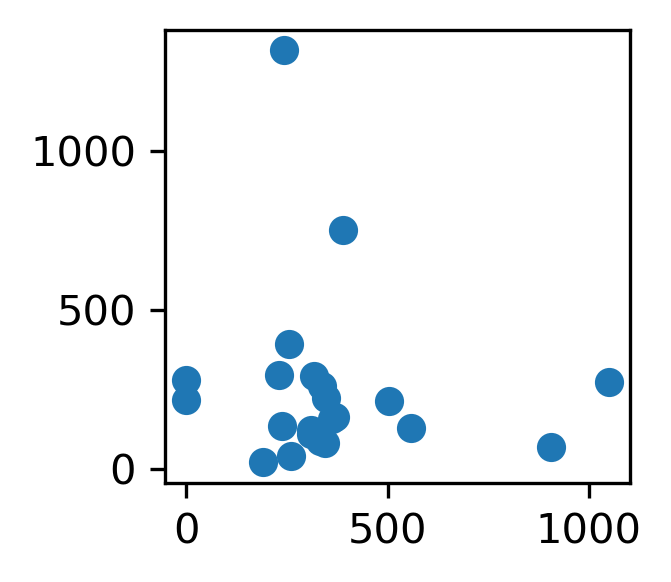

In [60]:
# Isolate monthly data of interest
circulation_oi = circulation[circulation['ZIP'] == shared_zips[0]]
monthly_circulation = circulation_oi.loc[:,"JANUARY":"DECEMBER"]

cases_oi = cases[cases['ZIP'] == shared_zips[0]]
monthly_cases = cases_oi.loc[:,"JANUARY":"DECEMBER"]
print(monthly_circulation)
print(monthly_cases)

# Generate plot
plt.rcParams.update({'figure.figsize':(2,2), 'figure.dpi':300})
plt.scatter(monthly_circulation, monthly_cases)